# Building Classification Models for Credit Default Risk in Taiwan

This project builds classification models to predict credit default risk meaning whether the customer is going to payback or default in Taiwan. 

The objective is to compare different models like logistic, Tree models based in key performance metrics like accuracy, precision, recall, and AUC. The focus is on improving risk assessment through probabilistic predictions.

Data : Link: https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

In [50]:
import os
import re
import glob
import json
import ast
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import RFE
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from collections import Counter
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, auc,
    precision_score, recall_score, f1_score,
    precision_recall_curve, classification_report,
    log_loss, brier_score_loss
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, chi2_contingency, spearmanr, pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve,classification_report, confusion_matrix
)

from scipy.stats import f_oneway, chi2_contingency


In [24]:
df=pd.read_excel("assgn.xls",skiprows=1)
print(df.shape)
df.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [25]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

## Exploratory Data Analysis : Univariate


In [26]:
# nulls percenatge (non nulls)
df.isna().sum()
# 100*df.isna().sum()/df.shape[0]

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [27]:
df.dtypes

ID                            int64
LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object

In [28]:
# X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
# X2: Gender (1 = male; 2 = female).
# X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
# X4: Marital status (1 = married; 2 = single; 3 = others).
# X5: Age (year).
# X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. 
# The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
# X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 
# X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.
df["PAY_0"].value_counts()

PAY_0
 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: count, dtype: int64

In [29]:
# for i in range(1, 7):
#     bill = df["BILL_AMT" + str(i)]
#     pay = df["PAY_AMT" + str(i)]
    
#     # Avoid division by zero: if bill == 0 → NaN
#     df["%paid_" + str(i)] = np.where(bill == 0, np.nan, 100 * pay / bill)


In [30]:
df.describe(percentiles=[.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99])

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
5%,1500.950000,20000.000000,1.000000,1.000000,1.000000,23.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
10%,3000.900000,30000.000000,1.000000,1.000000,1.000000,25.000000,-1.000000,-2.000000,-2.000000,-2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
20%,6000.800000,50000.000000,1.000000,1.000000,1.000000,27.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,988.000000,763.000000,476.000000,316.000000,2.688000e+02,2.80000,0.000000,0.000000,0.000000,0.000000
30%,9000.700000,70000.000000,1.000000,1.000000,1.000000,29.000000,0.000000,-1.000000,-1.000000,-1.000000,...,4643.700000,3637.000000,2701.700000,1263.700000,1.165000e+03,780.00000,500.000000,500.000000,426.000000,0.000000
40%,12000.600000,100000.000000,2.000000,2.000000,1.000000,31.000000,0.000000,0.000000,0.000000,0.000000,...,11145.000000,9809.200000,8770.200000,1724.000000,1.600000e+03,1206.00000,1000.000000,1000.000000,1000.000000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000


In [31]:
df["default payment next month"].value_counts(normalize=True)

default payment next month
0    0.7788
1    0.2212
Name: proportion, dtype: float64

Handling outliers

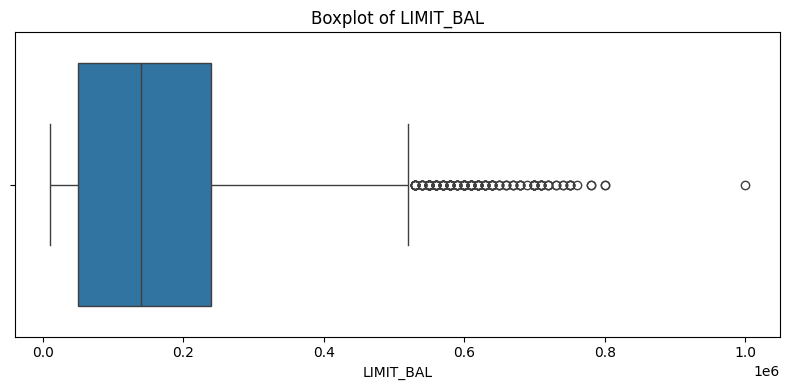

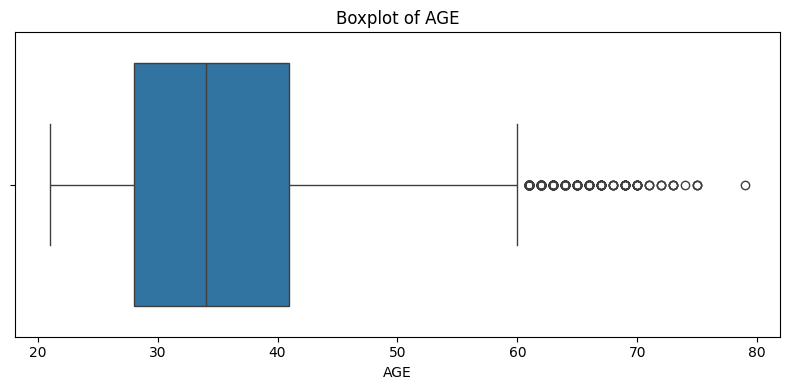

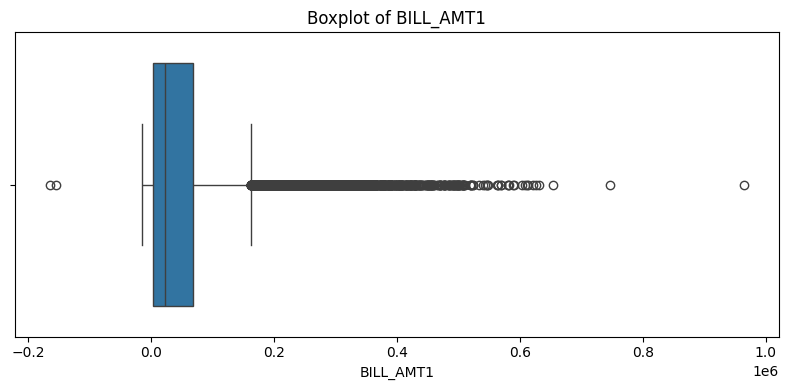

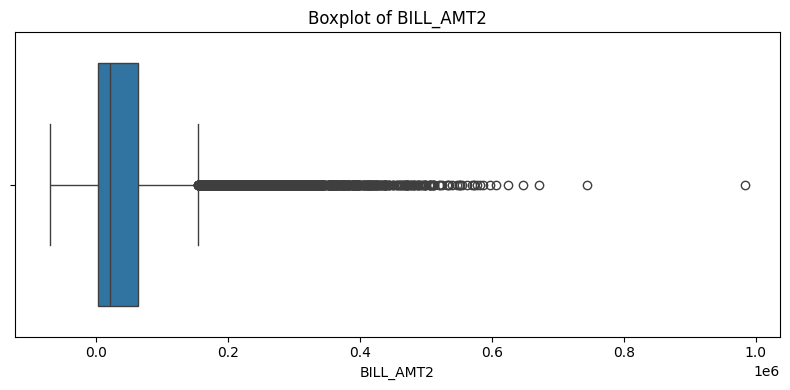

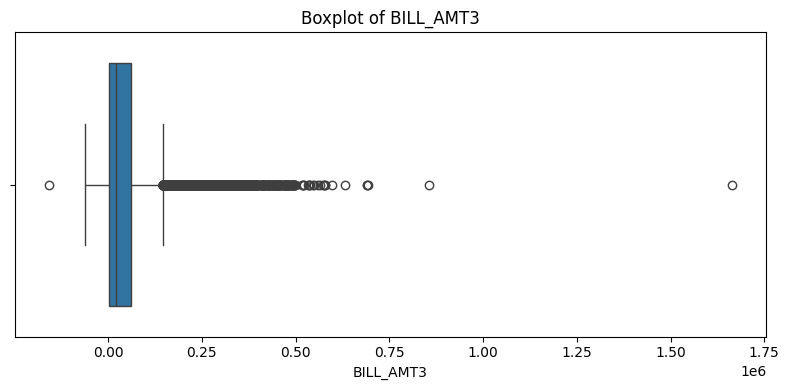

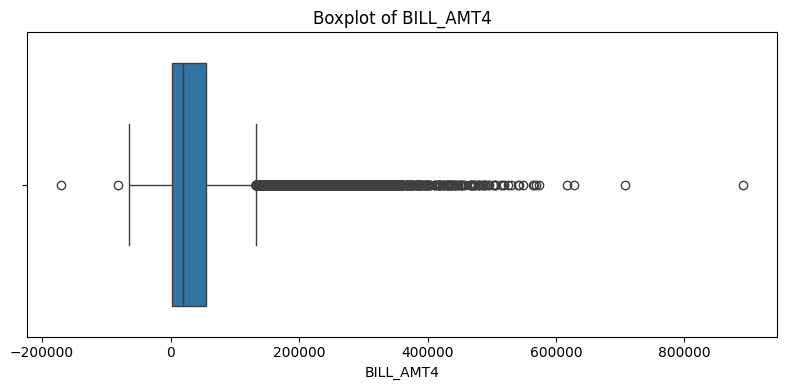

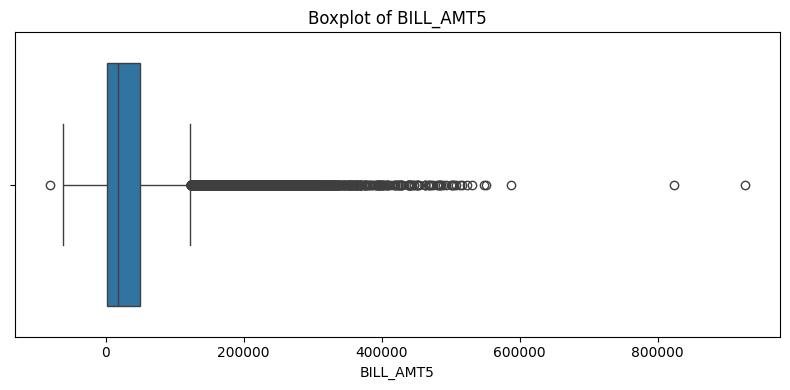

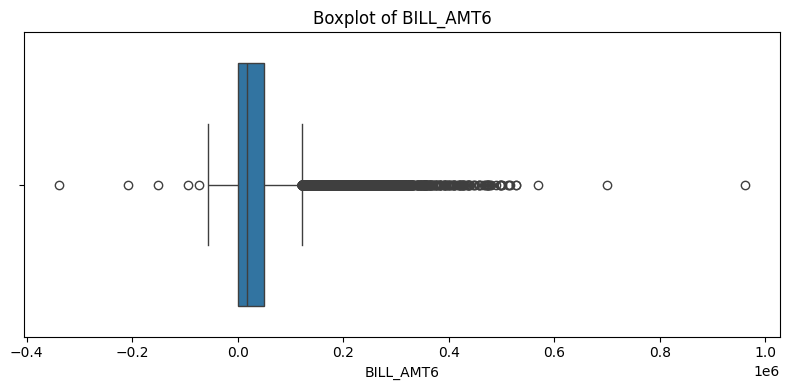

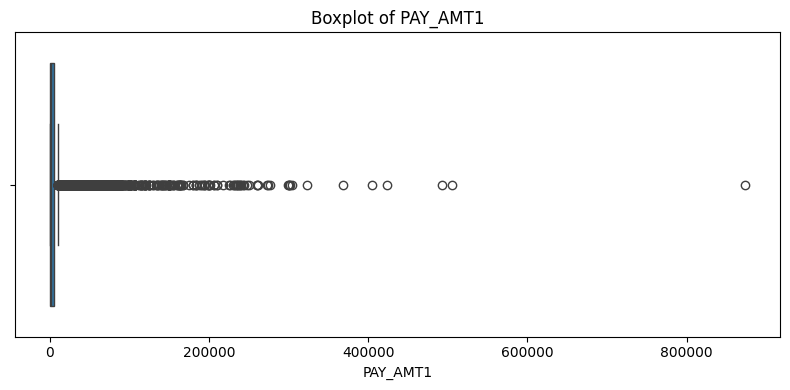

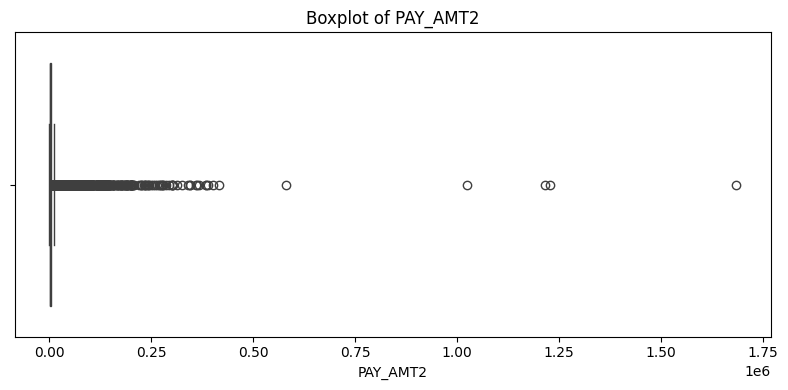

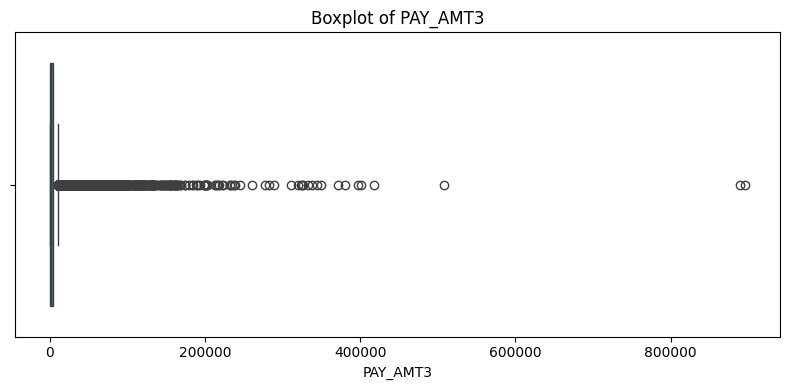

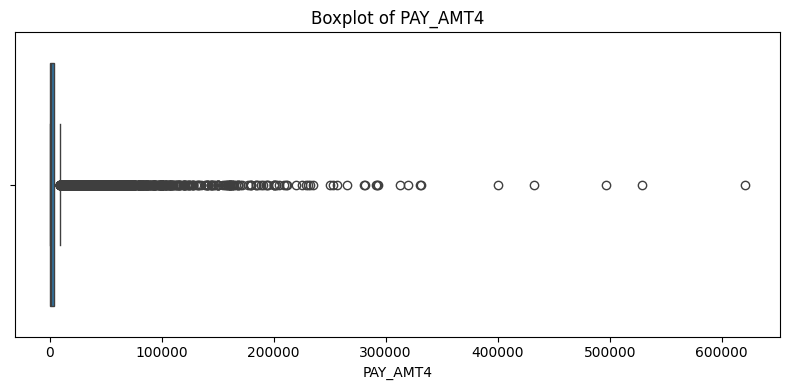

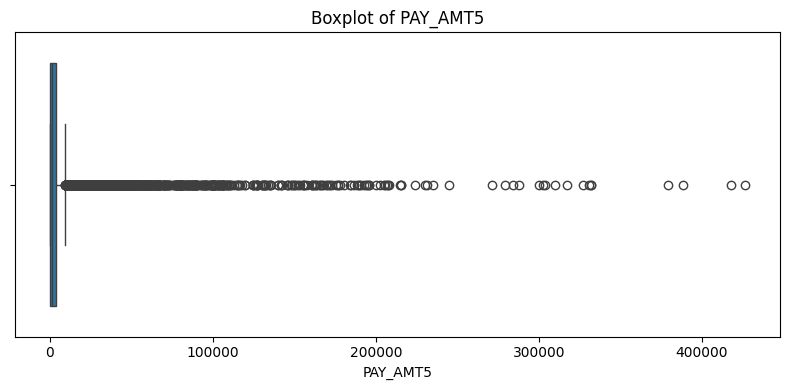

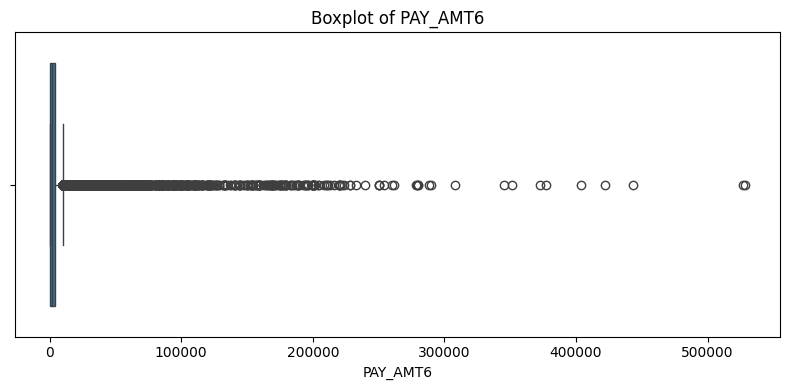

In [32]:
numerical_cols=[ 'LIMIT_BAL', 'AGE','BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',]

# Loop and plot individual boxplot for each feature
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()


In [34]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [35]:
def clip_outliers(df, features, lower_percentile=3, upper_percentile=97):
    for feature in features:
        lower = df[feature].quantile(lower_percentile / 100)
        upper = df[feature].quantile(upper_percentile / 100)
        df[feature] = df[feature].clip(lower=lower, upper=upper)
    return df

# Example usage:
features_to_clip = ['LIMIT_BAL','PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
df = clip_outliers(df, features_to_clip)


In [36]:
df[numerical_cols].describe(percentiles=[0.02,0.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.97,.99])

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000
mean,166973.256000,35.485500,48557.773900,46568.657600,44410.184033,40781.295433,38021.813900,36712.438400,4365.463767,4306.712767,3840.28080,3559.095833,3509.552133,3665.177200
std,127388.363597,9.217904,62536.764238,60216.945673,57909.283479,53713.521342,50882.181369,49952.149045,6050.767745,6186.159188,5800.97021,5659.987366,5458.497485,6154.368305
min,20000.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
2%,20000.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
5%,20000.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
10%,30000.000000,25.000000,278.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
20%,50000.000000,27.000000,1892.800000,1472.800000,1187.800000,988.000000,763.000000,476.000000,316.000000,268.800000,2.80000,0.000000,0.000000,0.000000
30%,70000.000000,29.000000,6050.400000,5500.000000,5219.200000,4643.700000,3637.000000,2701.700000,1263.700000,1165.000000,780.00000,500.000000,500.000000,426.000000
40%,100000.000000,31.000000,13469.200000,12799.600000,12197.200000,11145.000000,9809.200000,8770.200000,1724.000000,1600.000000,1206.00000,1000.000000,1000.000000,1000.000000


## Exploratory Data Analysis : Bivariate

### Correlation Plots

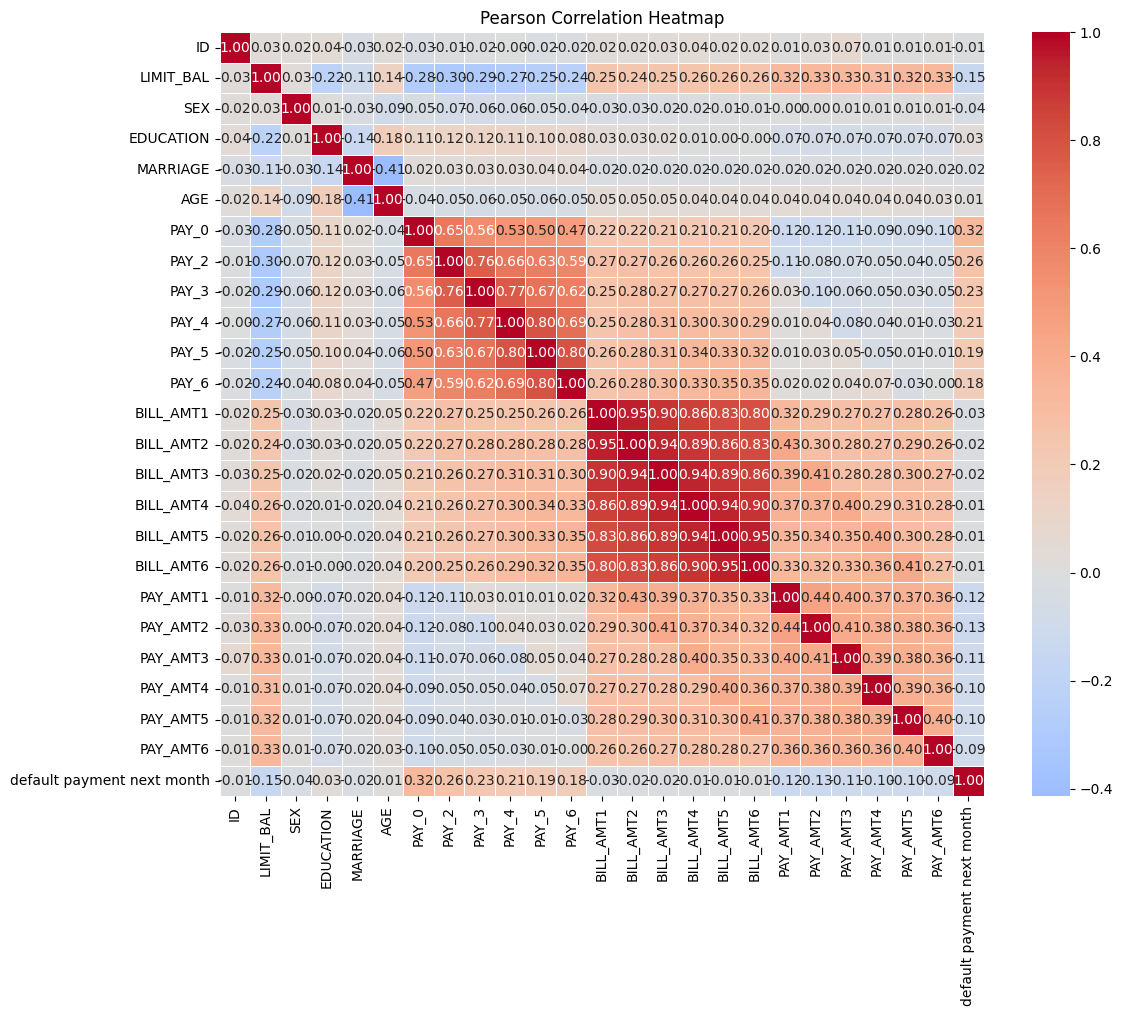

In [37]:
def plot_corr_heatmap(df, method='pearson', figsize=(12,10), title=None):
    """
    method: 'pearson' or 'spearman'
    """
    corr = df.corr(method=method)

    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, linewidths=0.5, square=True)
    plt.title(title or f'{method.capitalize()} Correlation Heatmap')
    plt.tight_layout()
    plt.show()

plot_corr_heatmap(df)

## FEATURE SELECTION

### ANOVA and CHI SQUARE for importance

 
 ANOVA (Analysis of Variance) tests whether the means of a numerical target differ  
significantly across categories of a categorical feature. It's useful for feature selection by identifying which categorical variables are statistically associated with the target.


In [38]:
def analyze_features(df, numerical_cols, categorical_cols, target):
    results = []

    # ANOVA for numerical vs categorical target
    for num_col in numerical_cols:
        try:
            df_clean = df[[num_col, target]].dropna()
            groups = df_clean[target].unique()
            group_data = [df_clean[df_clean[target] == grp][num_col] for grp in groups]

            f_stat, p_val = f_oneway(*group_data)
            results.append({
                'Feature': num_col,
                'Test': 'ANOVA',
                'F-statistic': round(f_stat, 4),
                'p-value': round(p_val, 4),
                'Degrees of Freedom': len(groups) - 1
            })
        except Exception as e:
            results.append({
                'Feature': num_col,
                'Test': 'ANOVA',
                'F-statistic': None,
                'p-value': None,
                'Degrees of Freedom': None,
                'Error': str(e)
            })

    # Chi-Square for categorical vs categorical target
    for cat_col in categorical_cols:
        try:
            df_clean = df[[cat_col, target]].dropna()
            table = pd.crosstab(df_clean[cat_col], df_clean[target])
            chi2, p, dof, _ = chi2_contingency(table)

            results.append({
                'Feature': cat_col,
                'Test': 'Chi-square',
                'F-statistic': None,
                'p-value': round(p, 4),
                'Degrees of Freedom': dof
            })
        except Exception as e:
            results.append({
                'Feature': cat_col,
                'Test': 'Chi-square',
                'F-statistic': None,
                'p-value': None,
                'Degrees of Freedom': None,
                'Error': str(e)
            })

    return pd.DataFrame(results)

def analyze_features(df, numerical_cols, categorical_cols, target):
    results = []

    # ANOVA: numerical vs categorical target
    for num_col in numerical_cols:
        try:
            df_clean = df[[num_col, target]].dropna()
            groups = df_clean[target].unique()
            group_data = [df_clean[df_clean[target] == grp][num_col] for grp in groups]

            f_stat, p_val = f_oneway(*group_data)
            results.append({
                'Feature': num_col,
                'Test': 'ANOVA',
                'Test Statistic': round(f_stat, 4),
                'p-value': round(p_val, 4),
                'Degrees of Freedom': len(groups) - 1
            })
        except Exception as e:
            results.append({
                'Feature': num_col,
                'Test': 'ANOVA',
                'Test Statistic': None,
                'p-value': None,
                'Degrees of Freedom': None,
                'Error': str(e)
            })

    # Chi-Square: categorical vs categorical target
    for cat_col in categorical_cols:
        try:
            df_clean = df[[cat_col, target]].dropna()
            table = pd.crosstab(df_clean[cat_col], df_clean[target])
            chi2, p, dof, _ = chi2_contingency(table)

            results.append({
                'Feature': cat_col,
                'Test': 'Chi-square',
                'Test Statistic': round(chi2, 4),
                'p-value': round(p, 4),
                'Degrees of Freedom': dof
            })
        except Exception as e:
            results.append({
                'Feature': cat_col,
                'Test': 'Chi-square',
                'Test Statistic': None,
                'p-value': None,
                'Degrees of Freedom': None,
                'Error': str(e)
            })

    return pd.DataFrame(results)


numerical_cols=[ 'LIMIT_BAL', 'AGE','BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',]

categorical_cols=['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']


analyze_features(df,numerical_cols,categorical_cols,"default payment next month")

,Feature,Test,Test Statistic,p-value,Degrees of Freedom
0,LIMIT_BAL,ANOVA,731.2038,0.0000,1
1,AGE,ANOVA,5.7886,0.0161,1
2,BILL_AMT1,ANOVA,21.0358,0.0000,1
3,BILL_AMT2,ANOVA,12.8231,0.0003,1
4,BILL_AMT3,ANOVA,10.7839,0.0010,1
5,BILL_AMT4,ANOVA,6.4656,0.0110,1
6,BILL_AMT5,ANOVA,4.1918,0.0406,1
7,BILL_AMT6,ANOVA,1.9402,0.1637,1
8,PAY_AMT1,ANOVA,470.3406,0.0000,1
9,PAY_AMT2,ANOVA,493.8498,0.0000,1


### VIF

VIF (Variance Inflation Factor) measures multicollinearity by quantifying how much a feature is explained by other features. A high VIF (typically >10) indicates strong correlation with other variables, suggesting redundancy and potential instability in regression models.

In [39]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, features):
    X = df[features].copy()
    X = X.dropna()  # VIF cannot handle NaNs
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

def reduce_vif(df, features, threshold=5.0):
    features = features.copy()
    while True:
        vif_df = calculate_vif(df, features)
        max_vif = vif_df["VIF"].max()
        if max_vif > threshold:
            max_feature = vif_df.sort_values("VIF", ascending=False)["feature"].iloc[0]
            print(f"Dropping '{max_feature}' with VIF={max_vif:.2f}")
            features.remove(max_feature)
        else:
            break
    return features, calculate_vif(df, features)

In [41]:
# Example usage:
features=['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',]
selected_features, final_vif = reduce_vif(df, features, threshold=5.0)
print("Selected features:", selected_features)
final_vif

Dropping 'BILL_AMT2' with VIF=35.19
Dropping 'BILL_AMT3' with VIF=23.83
Dropping 'AGE' with VIF=10.91
Dropping 'SEX' with VIF=8.10
Dropping 'BILL_AMT4' with VIF=7.68
Selected features: ['LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


,feature,VIF
0,LIMIT_BAL,3.711507
1,EDUCATION,3.911437
2,MARRIAGE,4.475920
3,PAY_0,1.863110
4,PAY_2,3.234804
5,PAY_3,3.768413
6,PAY_4,4.312836
7,PAY_5,4.796452
8,PAY_6,3.342914
9,BILL_AMT1,2.363514


## Data Preparation

### Train Test Val Split 

In [47]:
from sklearn.model_selection import train_test_split

# Split
X_train, X_test, y_train, y_test = train_test_split(df[selected_features], df["default payment next month"], test_size=0.3, random_state=42,stratify=df["default payment next month"])
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,stratify=y_test)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))

(21000, 16)
(4500, 16)
(4500, 16)
default payment next month
0    0.77881
1    0.22119
Name: proportion, dtype: float64
default payment next month
0    0.778667
1    0.221333
Name: proportion, dtype: float64
default payment next month
0    0.778889
1    0.221111
Name: proportion, dtype: float64


### Standardization and RFE

We use StandardScaler to standardize features by removing the mean and scaling to unit variance. This ensures that all features contribute equally to the model, especially important for algorithms like logistic regression, SVM, or k-NN that are sensitive to feature scales.

In [ ]:

def normalize_train_test(X_train, X_test,X_val):
    """
    Standardizes train and test data using StandardScaler (fit on train only).
    
    Parameters:
    X_train (pd.DataFrame): Training features
    X_test (pd.DataFrame): Testing features

    Returns:
    X_train_scaled (pd.DataFrame): Normalized training data
    X_test_scaled (pd.DataFrame): Normalized testing data
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)

    # Return as DataFrames with original column names and indices
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)


    return X_train_scaled, X_test_scaled ,X_val_scaled


X_train, X_test,X_val=normalize_train_test(X_train, X_test,X_val)

Recursive Feature Elimination (RFE) is a feature selection method that recursively removes the least important features based on a model’s weights or importance scores. It starts by training a model on all features, ranks them by importance, and removes the least significant one. The goal is to retain the most relevant and fixed number of features that improve model performance while reducing overfitting 

In [ ]:
from sklearn.feature_selection import RFE

def perform_rfe(X, y, estimator, n_features_to_select):
    """
    Perform Recursive Feature Elimination (RFE) to select top features.
    
    Parameters:
    X (pd.DataFrame): Features
    y (pd.Series): Target
    estimator: ML model object with `.fit()` method (e.g., LogisticRegression())
    n_features_to_select (int): Number of features to select

    Returns:
    list: Names of selected features
    """
    rfe = RFE(estimator=estimator, n_features_to_select=n_features_to_select)
    rfe.fit(X, y)
    selected_features = X.columns[rfe.support_].tolist()
    return selected_features

selected_features = perform_rfe(X_train, y_train, LogisticRegression(max_iter=1000), n_features_to_select=10)
print("Top selected final model features:", selected_features)


Top selected features: ['EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'BILL_AMT1', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3']


## Modelling and Hyper parameter tuning 

### Logistic Regression

In [75]:
def tune_logistic(X_train, y_train, X_test, y_test,model_feat):
    X_train=X_train[model_feat].copy()
    X_test=X_test[model_feat].copy()
    model = LogisticRegression(max_iter=1000)
    param_grid = {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['lbfgs']
    }

    grid = GridSearchCV(
        model,
        param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0,
        return_train_score=True
    )

    grid.fit(X_train, y_train)

    # Print full CV results
    print("CV Results (ROC AUC):")
    results = pd.DataFrame(grid.cv_results_)[[
        'params', 'mean_train_score', 'mean_test_score', 'rank_test_score'
    ]]
    print(results.sort_values('rank_test_score'))

    # Best estimator performance
    best_model = grid.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_train_prob = best_model.predict_proba(X_train)[:, 1]
    y_test_pred = best_model.predict(X_test)
    y_test_prob = best_model.predict_proba(X_test)[:, 1]

    print("\nTrain Set Metrics:")
    print(f"ROC AUC:   {roc_auc_score(y_train, y_train_prob):.4f}")
    print(f"Recall:    {recall_score(y_train, y_train_pred):.4f}")
    print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")

    print("\nTest Set Metrics:")
    print(f"ROC AUC:   {roc_auc_score(y_test, y_test_prob):.4f}")
    print(f"Recall:    {recall_score(y_test, y_test_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")

    return best_model


best_logistic = tune_logistic(X_train, y_train, X_test, y_test,selected_features)


CV Results (ROC AUC):
                                            params  mean_train_score  \
0  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}          0.727969   
1   {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}          0.727835   
2     {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}          0.727810   
3    {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}          0.727808   

   mean_test_score  rank_test_score  
0         0.727176                1  
1         0.726991                2  
2         0.726957                3  
3         0.726954                4  

Train Set Metrics:
ROC AUC:   0.7279
Recall:    0.2799
Precision: 0.6842

Test Set Metrics:
ROC AUC:   0.7191
Recall:    0.2610
Precision: 0.6566


### Random Forest

In [64]:
def tune_rf(X_train, y_train, X_test, y_test,model_feat):
    X_train=X_train[model_feat].copy()
    X_test=X_test[model_feat].copy()
    model = RandomForestClassifier(random_state=42)

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3,5,7],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    grid = GridSearchCV(
        model, param_grid,
        cv=5, scoring='roc_auc',
        n_jobs=-1, verbose=0,
        return_train_score=True
    )

    grid.fit(X_train, y_train)

    print("RF CV Results (ROC AUC):")
    results = pd.DataFrame(grid.cv_results_)[[
        'params', 'mean_train_score', 'mean_test_score', 'rank_test_score'
    ]]
    print(results.sort_values('rank_test_score'))

    best_model = grid.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_train_prob = best_model.predict_proba(X_train)[:, 1]
    y_test_pred = best_model.predict(X_test)
    y_test_prob = best_model.predict_proba(X_test)[:, 1]

    print("\nTrain Set Metrics:")
    print(f"ROC AUC:   {roc_auc_score(y_train, y_train_prob):.4f}")
    print(f"Recall:    {recall_score(y_train, y_train_pred):.4f}")
    print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")

    print("\nTest Set Metrics:")
    print(f"ROC AUC:   {roc_auc_score(y_test, y_test_prob):.4f}")
    print(f"Recall:    {recall_score(y_test, y_test_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")

    return best_model

tune_rf(X_train, y_train, X_test, y_test,selected_features)

RF CV Results (ROC AUC):
                                               params  mean_train_score  \
23  {'max_depth': 7, 'min_samples_leaf': 2, 'min_s...          0.793837   
17  {'max_depth': 7, 'min_samples_leaf': 1, 'min_s...          0.794531   
21  {'max_depth': 7, 'min_samples_leaf': 2, 'min_s...          0.793680   
22  {'max_depth': 7, 'min_samples_leaf': 2, 'min_s...          0.793473   
19  {'max_depth': 7, 'min_samples_leaf': 1, 'min_s...          0.794136   
18  {'max_depth': 7, 'min_samples_leaf': 1, 'min_s...          0.793859   
16  {'max_depth': 7, 'min_samples_leaf': 1, 'min_s...          0.794153   
20  {'max_depth': 7, 'min_samples_leaf': 2, 'min_s...          0.793212   
15  {'max_depth': 5, 'min_samples_leaf': 2, 'min_s...          0.775967   
13  {'max_depth': 5, 'min_samples_leaf': 2, 'min_s...          0.775967   
11  {'max_depth': 5, 'min_samples_leaf': 1, 'min_s...          0.776043   
9   {'max_depth': 5, 'min_samples_leaf': 1, 'min_s...          0.776094   


RandomForestClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

### XGBoost

In [65]:
from xgboost import XGBClassifier

def tune_xgb(X_train, y_train, X_test, y_test,model_feat):
    X_train=X_train[model_feat].copy()
    X_test=X_test[model_feat].copy()
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0]
    }

    grid = GridSearchCV(
        model, param_grid,
        cv=5, scoring='roc_auc',
        n_jobs=-1, verbose=0,
        return_train_score=True
    )

    grid.fit(X_train, y_train)

    print("XGB CV Results (ROC AUC):")
    results = pd.DataFrame(grid.cv_results_)[[
        'params', 'mean_train_score', 'mean_test_score', 'rank_test_score'
    ]]
    print(results.sort_values('rank_test_score'))

    best_model = grid.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_train_prob = best_model.predict_proba(X_train)[:, 1]
    y_test_pred = best_model.predict(X_test)
    y_test_prob = best_model.predict_proba(X_test)[:, 1]

    print("\nTrain Set Metrics:")
    print(f"ROC AUC:   {roc_auc_score(y_train, y_train_prob):.4f}")
    print(f"Recall:    {recall_score(y_train, y_train_pred):.4f}")
    print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")

    print("\nTest Set Metrics:")
    print(f"ROC AUC:   {roc_auc_score(y_test, y_test_prob):.4f}")
    print(f"Recall:    {recall_score(y_test, y_test_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")

    return best_model

tune_xgb(X_train, y_train, X_test, y_test,selected_features)


XGB CV Results (ROC AUC):
                                               params  mean_train_score  \
8   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...          0.794529   
10  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...          0.811430   
6   {'learning_rate': 0.01, 'max_depth': 5, 'n_est...          0.791987   
9   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...          0.792215   
11  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...          0.807988   
12  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...          0.841327   
7   {'learning_rate': 0.01, 'max_depth': 5, 'n_est...          0.791005   
4   {'learning_rate': 0.01, 'max_depth': 5, 'n_est...          0.784712   
13  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...          0.834672   
2   {'learning_rate': 0.01, 'max_depth': 3, 'n_est...          0.773306   
5   {'learning_rate': 0.01, 'max_depth': 5, 'n_est...          0.783104   
3   {'learning_rate': 0.01, 'max_depth': 3, 'n_est...          0.772428   

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

### Final Model 

In [ ]:
def get_metrics(y_true, y_pred, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_prob),
        'KS': max(tpr - fpr),
        'Gini': 2 * roc_auc_score(y_true, y_prob) - 1
    }

def compare_models(X_train, X_test, y_train, y_test, model_feat):
    X_train = X_train[model_feat].copy()
    X_test = X_test[model_feat].copy()
    
    models = {
        'LogisticRegression': tune_logistic(X_train, y_train, X_test, y_test, model_feat),
        'RandomForest': tune_rf(X_train, y_train, X_test, y_test, model_feat),
        'XGBoost': tune_xgb(X_train, y_train, X_test, y_test, model_feat)
    }

    results = []
    for name, model in models.items():
        # Test performance
        y_test_pred = model.predict(X_test)
        y_test_prob = model.predict_proba(X_test)[:, 1]
        test_metrics = get_metrics(y_test, y_test_pred, y_test_prob)
        test_metrics = {f'Test {k}': v for k, v in test_metrics.items()}

        # Train performance
        y_train_pred = model.predict(X_train)
        y_train_prob = model.predict_proba(X_train)[:, 1]
        train_metrics = get_metrics(y_train, y_train_pred, y_train_prob)
        train_metrics = {f'Train {k}': v for k, v in train_metrics.items()}

        # Combine metrics
        combined_metrics = {'Model': name}
        combined_metrics.update(train_metrics)
        combined_metrics.update(test_metrics)
        results.append(combined_metrics)

    results_df = pd.DataFrame(results).set_index('Model')
    return results_df

In [81]:
# Example usage:
results_df = compare_models(X_train,X_test,y_train,y_test,model_feat=selected_features)
results_df

CV Results (ROC AUC):
                                            params  mean_train_score  \
0  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}          0.727969   
1   {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}          0.727835   
2     {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}          0.727810   
3    {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}          0.727808   

   mean_test_score  rank_test_score  
0         0.727176                1  
1         0.726991                2  
2         0.726957                3  
3         0.726954                4  

Train Set Metrics:
ROC AUC:   0.7279
Recall:    0.2799
Precision: 0.6842

Test Set Metrics:
ROC AUC:   0.7191
Recall:    0.2610
Precision: 0.6566
RF CV Results (ROC AUC):
                                               params  mean_train_score  \
23  {'max_depth': 7, 'min_samples_leaf': 2, 'min_s...          0.793837   
17  {'max_depth': 7, 'min_samples_leaf': 1, 'min_s...          0.794531   
21  {'max_depth': 7, 'min_samp

,Train Accuracy,Train Precision,Train Recall,Train F1 Score,Train ROC AUC,Train KS,Train Gini,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test ROC AUC,Test KS,Test Gini
Model,,,,,,,,,,,,,,
LogisticRegression,0.812143,0.684211,0.279871,0.397250,0.727860,0.388714,0.455719,0.806222,0.656566,0.261044,0.373563,0.719087,0.374997,0.438175
RandomForest,0.829476,0.712630,0.383854,0.498951,0.789759,0.452854,0.579518,0.817778,0.666038,0.354418,0.462647,0.767543,0.423822,0.535086
XGBoost,0.825524,0.697862,0.372443,0.485682,0.791675,0.450079,0.583350,0.817111,0.662900,0.353414,0.461035,0.776336,0.425008,0.552673
